In [113]:
%load_ext autoreload
%autoreload 2
from IPython.display import Audio

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
from datasets.audio_compress import LibriTTS
from datasets.utils.diskcache import DiskCachedDataset
from models.pl_module_compress import MLPSNN

In [115]:
data_not_cache = LibriTTS('/home/romain/datasets/LibriTTS/', sampling_freq=16_000, sample_length=-1,)

directory already exist
Wave files are resampled to 16000Hz
Chunk map loaded from /home/romain/datasets/LibriTTS/debug/16000/full/-1_map.pkl
Waves files are splited into -1 samples length


In [116]:
data_not_cache

In [117]:
len(data_not_cache)

5736

In [118]:
import timeit
import random

# Assume `dataset` is your PyTorch Dataset
# Set the number of samples for timing
num_samples = 1000

# Generate a list of random indices
indices = [random.randint(0, len(data_not_cache) - 1) for _ in range(num_samples)]

# Time the average access time
average_time = timeit.timeit(
    stmt="data_not_cache[random.choice(indices)]",
    setup="from __main__ import data_not_cache, indices, random",
    number=num_samples
) / num_samples
average_time 
# around 5ms 
# it's too slow considering linear increase by the batch size,
# charging a 256 batch it will take, 256 * 5ms = 1.280 s
# we need to consider caching

0.0070266981440072415

In [119]:
from torch.utils.data import DataLoader
from datasets.utils.pad_tensors import PadTensors


In [120]:
num_samples = 10
it = iter(dataset)
average_time = timeit.timeit(
    stmt="next(it)",
    setup="from __main__ import it",
    number=num_samples
) / num_samples
average_time

NameError: name 'dataset' is not defined

In [ ]:
from omegaconf import DictConfig, omegaconf
import torch

In [379]:
#### configs
# 200 neuron
# cfg_path = '/home/romain/research_project/3sadlif/SE-adlif/results/hydra/2024-12-01/21-41-34/.hydra/config.yaml'
# 50 neuron
cfg_path = '/home/romain/research_project/3sadlif/SE-adlif/results/hydra/2024-12-01/22-32-16/.hydra/config.yaml'
# 16 neuron
# cfg_path = '/home/romain/research_project/3sadlif/SE-adlif/results/hydra/2024-12-02/08-56-40/.hydra/config.yaml'
# sparse 16 neuron
# cfg_path = '/home/romain/research_project/3sadlif/SE-adlif/results/hydra/2024-12-02/14-57-34/.hydra/config.yaml'
# 3 layer 16 neuron
# cfg_path = '/home/romain/research_project/3sadlif/SE-adlif/results/hydra/2024-12-02/12-21-51/.hydra/config.yaml'
#### checkpoints 
# 200 neuron
#ckpt_path = '/home/romain/research_project/3sadlif/SE-adlif/results/hydra/2024-12-01/17-04-45/ckpt/epoch=198-step=12338.ckpt'
# 50 neuron
ckpt_path = '/home/romain/research_project/3sadlif/SE-adlif/results/hydra/2024-12-01/22-32-16/ckpt/epoch=181-step=11284.ckpt'
# 16 neuron
# ckpt_path = '/home/romain/research_project/3sadlif/SE-adlif/results/hydra/2024-12-02/08-56-40/ckpt/epoch=126-step=7874.ckpt'
# 3 layer 16 neuron
# ckpt_path = '/home/romain/research_project/3sadlif/SE-adlif/results/hydra/2024-12-02/12-21-51/ckpt/epoch=12-step=806.ckpt'

# sparse 16 neuron
# ckpt_path = '/home/romain/research_project/3sadlif/SE-adlif/results/hydra/2024-12-02/14-57-34/ckpt/epoch=24-step=1550.ckpt'


In [380]:
cfg = omegaconf.OmegaConf.load(cfg_path)
ckpt = torch.load(ckpt_path)
ckpt_state_dict = ckpt['state_dict']

In [381]:
ckpt_state_dict['model.decoder.out_layer.weight'].shape
del model

In [382]:
model = MLPSNN(cfg)

model.load_state_dict(ckpt_state_dict)

{'random_seed': 42, 'logdir': './results', 'datadir': '/home/romain/datasets', 'device': 'cuda:0', 'dataset': {'_target_': 'datasets.audio_compress.CompressLibri', 'name': 'Compress libri task', 'required_model_size': 'small', 'data_path': '${datadir}', 'max_sample': 10000, 'sampling_freq': 16000, 'sample_length': 512, 'prediction_delay': 0, 'batch_size': 128, 'num_workers': 8, 'fits_into_ram': True, 'num_classes': 1}, 'exp_name': 'compres_libri_SE_adLIF', 'cell': 'se_adlif', 'auto_regression': True, 'input_size': 1, 'n_neurons': 600, 'n_neurons_big': 600, 'n_neurons_small': 50, 'first_layer_use_recurrent': False, 'first_layer_thr': 0.1, 'ff_gain': 10, 'use_recurrent': True, 'light_decoder': True, 'q': 120, 'tau_u_range': [5, 25], 'tau_w_range': [60, 300], 'alpha': 5.0, 'c': 0.4, 'thr': 1.0, 'dt': 1.0, 'n_epochs': 200, 'dropout': 0.0, 'tau_out_range': [1, 20], 'train_tau_out_method': 'interpolation', 'loss_agg': 'MSE', 'tracking_metric': 'val_loss', 'tracking_mode': 'min', 'lr': 0.01, 

/home/romain/.conda/envs/SE-adLIF/lib/python3.11/site-packages/torch/jit/_recursive.py:320: UserWarning: 'in_features' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  warnings.warn(


<All keys matched successfully>

In [383]:
model.eval()

MLPSNN(
  (model): RecursiveScriptModule(
    original_name=Net
    (encoder): RecursiveScriptModule(
      original_name=Encoder
      (l1): RecursiveScriptModule(
        original_name=SEAdLIF
        (tau_u_trainer): RecursiveScriptModule(original_name=InterpolationTrainer)
        (tau_w_trainer): RecursiveScriptModule(original_name=InterpolationTrainer)
      )
      (l2): RecursiveScriptModule(
        original_name=SEAdLIF
        (tau_u_trainer): RecursiveScriptModule(original_name=InterpolationTrainer)
        (tau_w_trainer): RecursiveScriptModule(original_name=InterpolationTrainer)
      )
    )
    (decoder): RecursiveScriptModule(
      original_name=Decoder
      (out_layer): RecursiveScriptModule(
        in_features=50, out_features=1, bias=True
        (tau_u_trainer): RecursiveScriptModule(original_name=InterpolationTrainer)
      )
    )
  )
  (loss): MultiScaleMelSpetroLoss(
    (mel_banks): ModuleList(
      (0-3): 4 x MelSpectrogram(
        (spectrogram): Spectro

In [384]:
inputs, *rest = data_not_cache[1]

In [385]:
x = inputs.unsqueeze(0)

In [386]:
with torch.no_grad():
    noise = model(torch.zeros_like(inputs.unsqueeze(0)))
    



In [387]:
with torch.no_grad():
     = model(x)

In [388]:
from scipy.signal import spectrogram, ShortTimeFFT
ShortTimeFFT()
sampling_freq = 16_000
frequencies, times, Sxx = ShortTimeFFT(noise.cpu().numpy().squeeze(), fs=sampling_freq, nperseg=1024)

# Plot the STFT (spectrogram)
plt.figure(figsize=(12, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap='viridis')
plt.title("Short-Time Fourier Transform (Spectrogram)")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (s)")
plt.colorbar(label="Power (dB)")
plt.ylim(0, 5000)  # Limit to a reasonable frequency range
plt.show()

TypeError: ShortTimeFFT.__init__() missing 3 required positional arguments: 'win', 'hop', and 'fs'

In [376]:
import numpy as np

import matplotlib.pyplot as plt

from scipy.signal import ShortTimeFFT

from scipy.signal.windows import hann,gaussian

g_std = 8  # standard deviation for Gaussian window in samples

w = hann(128, sym=True)  # symmetric Gaussian window

SFT = ShortTimeFFT(w, hop=5, fs=16_000, mfft=512)
N = len(noise.cpu().numpy().squeeze())

Sx_noise = SFT.stft(noise.cpu().numpy().squeeze())  # perform the STFT

noise_power = 0.5*np.max(np.abs(Sx_noise), -1)[:, None]
print(noise_power)
Sx_signal = SFT.stft(y.cpu().numpy().squeeze())
clean_power = np.maximum(np.abs(Sx_signal) - noise_power, 0)
clean_signal = clean_power * np.exp(1j*np.angle(Sx_signal))
x1_a = SFT.istft(clean_signal)
spec = SFT.spectrogram(noise.cpu().numpy().squeeze())

[[0.06458605]
 [0.0632209 ]
 [0.05930765]
 [0.05335742]
 [0.04611253]
 [0.03914118]
 [0.03770343]
 [0.03552142]
 [0.03253091]
 [0.029357  ]
 [0.03078288]
 [0.03185971]
 [0.03268192]
 [0.03328795]
 [0.03363559]
 [0.03376421]
 [0.03361137]
 [0.03266382]
 [0.03084989]
 [0.02824631]
 [0.025057  ]
 [0.02176756]
 [0.01857294]
 [0.01568727]
 [0.01386654]
 [0.01335525]
 [0.01307513]
 [0.01297743]
 [0.01299933]
 [0.01307832]
 [0.01316151]
 [0.01320912]
 [0.01319368]
 [0.01309743]
 [0.01291018]
 [0.01262867]
 [0.01225789]
 [0.01188099]
 [0.01146477]
 [0.01101423]
 [0.01066994]
 [0.01056764]
 [0.01010737]
 [0.00969256]
 [0.00917244]
 [0.00901999]
 [0.00888899]
 [0.00879196]
 [0.00866734]
 [0.00848996]
 [0.00831835]
 [0.00837089]
 [0.00833906]
 [0.00812839]
 [0.00779353]
 [0.00773937]
 [0.00770054]
 [0.00766501]
 [0.00768226]
 [0.00763109]
 [0.00747505]
 [0.00719389]
 [0.00678752]
 [0.0062774 ]
 [0.00598238]
 [0.00649384]
 [0.0068805 ]
 [0.00706148]
 [0.00703577]
 [0.00680226]
 [0.00643215]
 [0.00

In [377]:
Audio(y.cpu().numpy().squeeze(), rate=sampling_freq)

In [188]:
import numpy as np
from scipy.signal import istft
def compute_noise_powerspectrum(waveform, sampling_freq):
    print(waveform.shape)
    # Calculate noise profile
    _, _, Sxx =  spectrogram(waveform, fs=sampling_freq, nperseg=1024)
    noise_power = np.mean(Sxx, axis=1)
    return noise_power
    # Perform STFT on the full waveform
    
def substract_noise_spectrum(waveform, noise_power, sampling_freq):
    frequencies, times, Sxx = spectrogram(waveform, fs=sampling_freq, nperseg=1024)
    # Subtract noise spectrum
    Sxx_clean = Sxx - noise_power[:, None]
    Sxx_clean[Sxx_clean < 0] = 1e-9  # Ensure no negative values

    # Reconstruct waveform (inverse STFT approximation)
    reconstructed_waveform = istft(Sxx_clean, fs=sampling_freq, nperseg=1024)
    return (frequencies, times, Sxx_clean), reconstructed_waveform

(82720,)


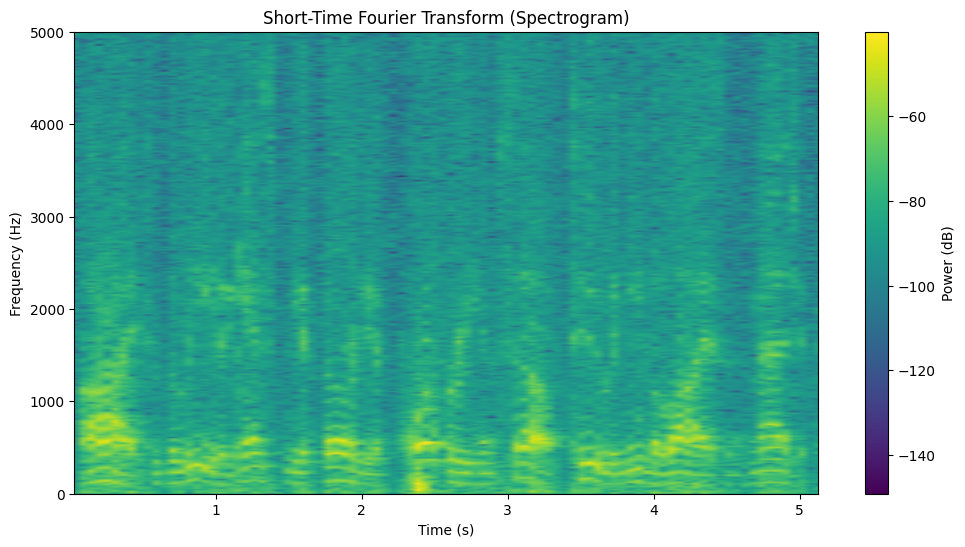

In [189]:
# Plot the STFT (spectrogram)
noise_power = compute_noise_powerspectrum(noise.cpu().numpy().squeeze(), sampling_freq)
(frequencies, times, Sxx), y_clean = substract_noise_spectrum(y.cpu().numpy().squeeze(), noise_power, sampling_freq)
plt.figure(figsize=(12, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap='viridis')
plt.title("Short-Time Fourier Transform (Spectrogram)")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (s)")
plt.colorbar(label="Power (dB)")
plt.ylim(0, 5000)  # Limit to a reasonable frequency range
plt.show()


In [190]:
y_clean

(array([0.0000000e+00, 6.2500000e-05, 1.2500000e-04, ..., 2.9118125e+00,
        2.9118750e+00, 2.9119375e+00]),
 array([-5.8994232e-09, -5.7090324e-09, -8.8908427e-09, ...,
        -4.0760234e-08, -4.1198476e-08, -4.4452978e-08], dtype=float32))

In [233]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.fft import fft, ifft
from IPython.display import Audio

# Parameters for waveform generation
sampling_rate = 16_000  # Sampling rate in Hz
# Time vector

# Perform FFT
fft_result = fft(y.cpu().numpy().squeeze())
frequencies = np.fft.fftfreq(len(fft_result), 1 / sampling_rate)
fft_noise = fft(noise.cpu().numpy().squeeze())

# Compute power spectra (magnitude squared)
power_noisy_signal = np.abs(fft_result)**2
power_noise = np.abs(fft_noise)**2

# Subtract noise power spectrum from noisy signal power spectrum
power_denoised_signal = np.maximum(power_noisy_signal - power_noise, 0)

# Reconstruct the denoised FFT (preserving phase)
phase_noisy_signal = np.angle(fft_result)
fft_denoised_signal = np.sqrt(power_denoised_signal) * np.exp(1j * phase_noisy_signal)

# Reconstruct the waveform using IFFT
reconstructed_waveform = np.real(ifft(fft_denoised_signal))

In [234]:
Audio(data=y.cpu().numpy().squeeze(), rate=sampling_rate)

In [235]:
Audio(data=reconstructed_waveform, rate=sampling_rate)


In [245]:
Audio(x1, rate=16_000)

In [191]:
Audio(y_clean[1].squeeze(), rate=16_000,)

In [214]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.fft import fft, ifft
from IPython.display import Audio

# Parameters
sampling_rate = 44100  # Sampling rate in Hz
duration = 2  # Duration in seconds
signal_freq = 440  # Frequency of the signal (A4 note)
noise_amplitude = 0.3  # Amplitude of the noise


# Generate example noise (white noise)

# Perform FFT on the noisy signal and noise
fft_noisy_signal = fft(noisy_signal)
fft_noise = fft(noise_waveform)

# Subtract the noise spectrum from the noisy signal spectrum
fft_denoised_signal = fft_noisy_signal - fft_noise
denoised_signal = np.real(ifft(fft_denoised_signal))
# Reconstruct the denoised signal using IFFT
